In [2]:
import pandas as pd
raw_data = pd.read_csv('/Users/teacher/repos/s20_ds_nlp/classes/week_7/data/headlines', error_bad_lines=False);
#raw_data = pd.read_csv(datafile, parse_dates=[0], infer_datetime_format=True)

reindexed_data = raw_data['headline_text']
reindexed_data.index = raw_data['publish_date']

display(raw_data.head())

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit
3,20030219,air nz staff in aust strike for pay rise
4,20030219,air nz strike to affect australian travellers


In [3]:
from sklearn.feature_extraction.text import CountVectorizer

small_count_vectorizer = CountVectorizer(stop_words='english', max_features=400)
small_text_sample = reindexed_data.sample(n=10000, random_state=0).as_matrix()

display(small_text_sample)
small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)
display(small_document_term_matrix)


/Users/teacher/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


array(['spanish protest against prestige disaster',
       'opposition to second regulated power interconnector',
       'sydney roosters kick off season with victory', ...,
       'blaze damages nimmitabel hotel',
       'oppn says bacon denying his heritage',
       'community gets behind striking miners'], dtype=object)

<10000x400 sparse matrix of type '<class 'numpy.int64'>'
	with 19229 stored elements in Compressed Sparse Row format>

In [4]:
from sklearn.decomposition import TruncatedSVD

n_topics = 8

lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(small_document_term_matrix)
display(lsa_topic_matrix)

array([[ 4.97462192e-02,  7.53418167e-02, -6.48280273e-03, ...,
        -5.44955089e-03,  2.96589886e-04,  5.40236663e-03],
       [ 1.41627442e-02,  3.28245294e-03,  1.75764097e-02, ...,
         1.35016890e-02,  2.06148567e-02,  9.96882920e-03],
       [ 1.38515595e-02,  2.14417736e-02,  1.47062823e-02, ...,
         1.10651117e-02,  3.45193677e-03,  1.05955197e-03],
       ...,
       [ 7.32806241e-04,  3.38844009e-03,  1.31888222e-02, ...,
         3.78263825e-05,  1.66357914e-03,  6.07541405e-03],
       [ 1.44626072e-01, -1.03874815e-01,  5.15039990e-02, ...,
         2.24472374e-02,  8.67641942e-01, -1.25860851e-01],
       [ 3.16488054e-03,  3.25189926e-03,  1.39123784e-02, ...,
         2.14983577e-02,  1.15230120e-02,  1.46529331e-02]])

In [5]:
from collections import Counter
# Define helper functions
def get_keys(topic_matrix):
    '''returns an integer list of predicted topic categories for a given topic matrix'''
    keys = []
    for i in range(topic_matrix.shape[0]):
        keys.append(topic_matrix[i].argmax())
    return keys

def keys_to_counts(keys):
    '''returns a tuple of topic categories and their accompanying magnitudes for a given list of keys'''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [6]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [7]:
# Define helper functions
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''returns a list of n_topic strings, where each string contains the n most common 
        words in a predicted category, in order'''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [8]:
import numpy as np
top_n_words_lsa = get_top_n_words(10, lsa_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i), top_n_words_lsa[i])

Topic 0:  iraq war pm aust howard troops bush says denies turkey
Topic 1:  war anti protest protesters students rally protests sydney greens march
Topic 2:  police death probe crash car missing clash search coast drug
Topic 3:  govt nsw qld claims vic drought health report urged wa
Topic 4:  man court face charged murder dies hospital charges trial charge
Topic 5:  new sars set takes hopes work resolution hits high record
Topic 6:  iraqi says baghdad cup win world killed korea troops forces
Topic 7:  council water plan rain security funds centre concerns seeks welcomes


Text(0.5,1,'LSA Topic Category Counts')

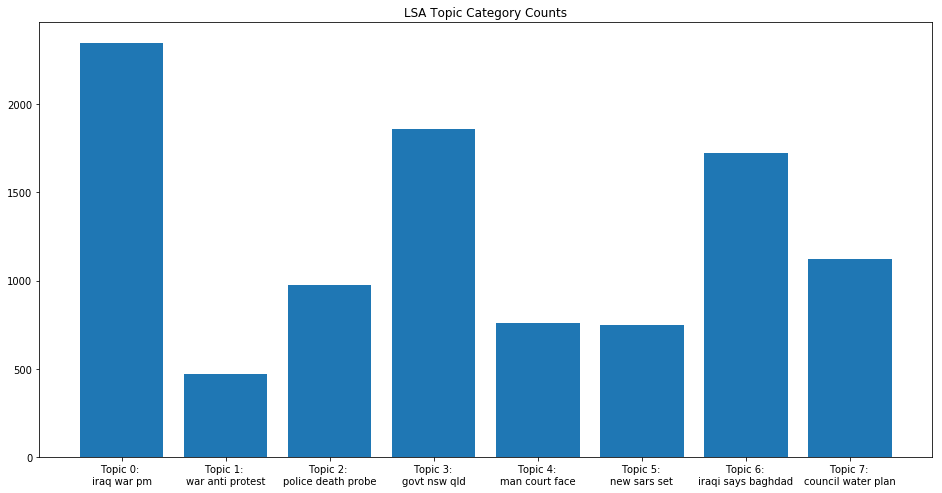

In [9]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

%matplotlib inline
top_3_words = get_top_n_words(3, lsa_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lsa_categories, lsa_counts)
ax.set_xticks(lsa_categories)
ax.set_xticklabels(labels)
ax.set_title('LSA Topic Category Counts')